Pierre-Eliott THIBOUD  
Julien PERIER-CAMBY  

# IBI - TP1
## Partie 1

In [1]:
import gzip # pour décompresser les données
import pickle # pour désérialiser les données
import numpy # pour pouvoir utiliser des matrices
import matplotlib.pyplot as plt # pour l'affichage
import torch,torch.utils.data

In [2]:
def affichage(image,label):
    # on récupère à quel chiffre cela correspond (position du 1 dans label)
    label = numpy.argmax(label)
    # on crée une figure
    plt.figure()
    # affichage du chiffre
    # le paramètre interpolation='nearest' force python à afficher chaque valeur de la matrice sans l'interpoler avec ses voisines
    # le paramètre cmap définit l'échelle de couleur utilisée (ici noire et blanc)
    plt.imshow(image.reshape((28,28)),interpolation='nearest',cmap='binary')
    # on met un titre
    plt.title('chiffre '+str(label))
    # on affichage les figures créées
    plt.show()

### Chargement des données

In [4]:
data = pickle.load(gzip.open('mnist.pkl.gz'),encoding='latin1')

train_data = data[0][0]
train_lab = data[0][1]
test_data = data[1][0]
test_lab = data[1][1]

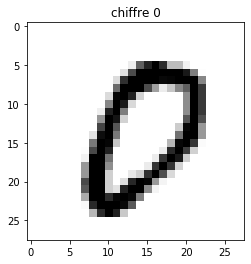

In [9]:
affichage(train_data[0], train_lab[0])

In [ ]:
import numpy as np